In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prep

Goals:

Using saas.csv or log data from API usage:

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.


Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Last Observed
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.shape

(790458, 5)

In [4]:
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [5]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
# check max date
df['Month_Invoiced'].max()

'2017-12-31'

In [7]:
# check min date
df['Month_Invoiced'].min()

'2014-01-31'

In [8]:
df = df.rename(columns={'Month_Invoiced':'date', 'Customer_Id':'customer_id', 'Invoice_Id':'invoice_id','Subscription_Type':'subscription_type','Amount':'amount'})

In [9]:
# convert date data type to datetime64
df['date'] = df['date'].astype('datetime64')

In [10]:
df.dtypes

date                 datetime64[ns]
customer_id                   int64
invoice_id                    int64
subscription_type           float64
amount                      float64
dtype: object

In [11]:
# sort month_invoice column and set it as the index
df = df.sort_values('date').set_index('date')

In [12]:
df.head()

,customer_id,invoice_id,subscription_type,amount
date,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0


In [13]:
# drop irrelevant columns
df = df.drop(columns={'customer_id','invoice_id', 'subscription_type' })

In [14]:
# resample by month
df = df.resample('M').sum()

In [15]:
# preview
df.head(15)

,amount
date,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


## Split Data

In [16]:
train_size = int(len(df.index)*.75)
train, test = df[:train_size], df[(train_size):]

In [17]:
len(train), len(test)

(36, 12)

In [18]:
train.tail()

,amount
date,
2016-08-31,52940.0
2016-09-30,52975.0
2016-10-31,53190.0
2016-11-30,53375.0
2016-12-31,53320.0


In [19]:
test.head()

,amount
date,
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0


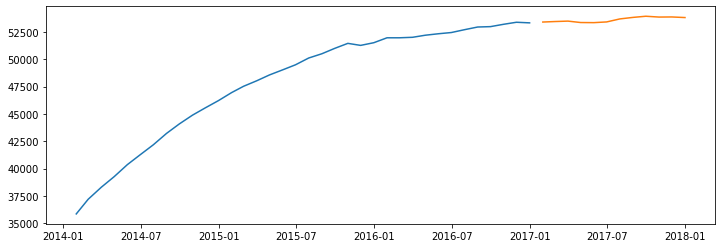

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

## Modeling

#### Create a dataframe that contains the actual y test values and a column for each predictive y test values

### Last Observed

In [21]:
# create df with actual y test amounts
predictions = pd.DataFrame(test.amount)

In [22]:
# add column that would predict test amounts using the last observed y value in train
predictions['last_observed'] = int(train.amount[-1:])

In [23]:
predictions.head(3)

,amount,last_observed
date,,
2017-01-31,53395.0,53320
2017-02-28,53440.0,53320
2017-03-31,53480.0,53320


### Simple Average

In [24]:
# predict y test using average of train
predictions['simple_average'] = train.amount.mean()

In [25]:
predictions.head(3)

,amount,last_observed,simple_average
date,,,
2017-01-31,53395.0,53320,47916.666667
2017-02-28,53440.0,53320,47916.666667
2017-03-31,53480.0,53320,47916.666667


### Moving Average


In [26]:
# using last 6 months' average
predictions['last_6_months'] = train.amount.rolling(6).mean().iloc[-1]

In [27]:
predictions.head(3)

,amount,last_observed,simple_average,last_6_months
date,,,,
2017-01-31,53395.0,53320,47916.666667,53082.5
2017-02-28,53440.0,53320,47916.666667,53082.5
2017-03-31,53480.0,53320,47916.666667,53082.5


### Holt's Linear Trend Model

In [28]:
model = Holt(train['amount']).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
predictions['holt_linear'] = pd.DataFrame(model.forecast(test['amount'].shape[0]), columns=['amount'])

In [30]:
predictions.head(3)

,amount,last_observed,simple_average,last_6_months,holt_linear
date,,,,,
2017-01-31,53395.0,53320,47916.666667,53082.5,54025.435756
2017-02-28,53440.0,53320,47916.666667,53082.5,54260.908478
2017-03-31,53480.0,53320,47916.666667,53082.5,54496.381201


### Based on previous year

In [31]:
predictions['last_year'] = np.array(train.tail(12))

In [32]:
predictions.head(3)

,amount,last_observed,simple_average,last_6_months,holt_linear,last_year
date,,,,,,
2017-01-31,53395.0,53320,47916.666667,53082.5,54025.435756,51955.0
2017-02-28,53440.0,53320,47916.666667,53082.5,54260.908478,51955.0
2017-03-31,53480.0,53320,47916.666667,53082.5,54496.381201,52000.0


## Evaluate the Models

In [33]:
predictions.head()

,amount,last_observed,simple_average,last_6_months,holt_linear,last_year
date,,,,,,
2017-01-31,53395.0,53320,47916.666667,53082.5,54025.435756,51955.0
2017-02-28,53440.0,53320,47916.666667,53082.5,54260.908478,51955.0
2017-03-31,53480.0,53320,47916.666667,53082.5,54496.381201,52000.0
2017-04-30,53350.0,53320,47916.666667,53082.5,54731.853923,52190.0
2017-05-31,53340.0,53320,47916.666667,53082.5,54967.326645,52325.0


In [36]:
mse = metrics.mean_squared_error(test['amount'], predictions['last_observed'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  133958.33333333334
RMSE: 366.0031875999625


In [42]:
mse = metrics.mean_squared_error(test['amount'], predictions['simple_average'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  32490919.444444474
RMSE: 5700.080652450847


In [43]:
mse = metrics.mean_squared_error(test['amount'], predictions['last_6_months'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  329302.0833333333
RMSE: 573.8484846484596


In [44]:
mse = metrics.mean_squared_error(test['amount'], predictions['holt_linear'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  3322972.768449215
RMSE: 1822.9022926227328


In [45]:
mse = metrics.mean_squared_error(test['amount'], predictions['last_year'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  1111593.75
RMSE: 1054.321464260308


## Plot the Models

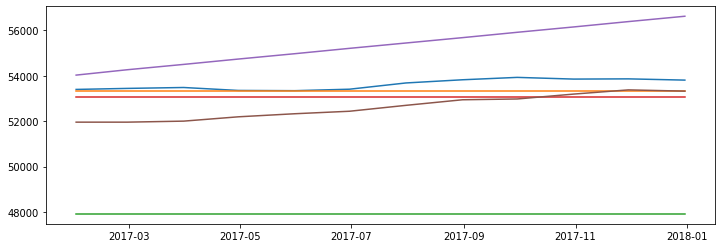

In [54]:
plt.figure(figsize=(12, 4))
plt.plot(test)
plt.plot(predictions.last_observed)
plt.plot(predictions.simple_average)
plt.plot(predictions.last_6_months)
plt.plot(predictions.holt_linear)
plt.plot(predictions.last_year)